# Análisis Exploratorio de Datos.



In [6]:
import time
import pyodbc
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from app.database_tools.connections import connect_to_fetch_data
from app.main_functions.forecasting import predictions_orchestrator
from app.main_functions.novelty_detection import detect_atypical_values
from app.main_functions.inserting_data import (
    check_tables_exist,
    fetch_new_data,
    update_database
)
from app.database_tools.connections import (
    connect_to_insert_data,
    connect_to_fetch_data,
    connect_to_insert_forecasting_data
)

Extraemos la data desde la base de datos llamada WLMDW_TEMPO usando la función de conexión construida en el script alojado en /app/database_tools/connections.py. y usamos pandas para manipular la data como un DataFrame.

In [3]:
conn_fetch = connect_to_fetch_data()
query = "SELECT * FROM dbo.refrescarprocesos_10dias"
df = pd.read_sql(query, conn_fetch)

Connection to the database for fetching data was successful.


In [7]:
load_dotenv()

def main():
    """
    Main function to update consumption data and execute forecasting.

    This function performs the following steps:
    1. Creates connections to the databases for inserting data, fetching data, and inserting forecasting data.
    2. Updates the consumption data by checking if the necessary tables exist, fetching new data, and updating the database.
    3. Executes the forecasting process using the updated data.

    If a database or file error occurs, it catches the exception and prints an error message.

    Finally, it ensures that all database connections are closed.

    Raises:
        pyodbc.DatabaseError: If a database error occurs.
        FileNotFoundError: If a file-related error occurs.
    """
    while True:
        try:
            print("Updating Consumption Data...")
            conn_insert = connect_to_insert_data()
            conn_fetch = connect_to_fetch_data()
            conn_insert_predictions = connect_to_insert_forecasting_data()
            check_tables_exist(conn_insert)
            new_data = fetch_new_data(conn_insert, conn_fetch)
            updated_data = update_database(conn_insert, new_data)
            return updated_data
        except (pyodbc.DatabaseError, FileNotFoundError) as e:
            print(f"A database or file error occurred: {e}")
            print("Retrying in 5 seconds...")
            time.sleep(5)
        finally:
            try:
                conn_insert.close()
                conn_fetch.close()
                conn_insert_predictions.close()
            except NameError:
                pass

In [8]:
df_to_update = main()

Updating Consumption Data...
Connection to the database for inserting data was successful.
Connection to the database for fetching data was successful.
Connection to the database for inserting forcasts data was successful.
Checking if tables exist...
9 tables exist.
Some tables are missing.
Deleting tables...
Tables deleted.
Creating tables...
Tables created successfully.
Fetching new data...
Updating the Procesos table.
Updating the Grupos table.
Updating the Fechas table.
Updating the ProcesosGrupos table.
Identifying if the data already exists.
The new data from the dataset is able to be inserted.


In [9]:
conn_insert = connect_to_insert_data()

Connection to the database for inserting data was successful.


In [10]:
print(detect_atypical_values(conn_insert, df_to_update))

Detecting atypical values...


KeyboardInterrupt: 

In [11]:
def segment_data(df):
    """
    Segments the input DataFrame into predefined date ranges.
    Args:
        df (pd.DataFrame): Input DataFrame containing a 'Fecha' column with date values.
    Returns:
        list of pd.DataFrame: A list of DataFrames, each corresponding
          to a segment of the input DataFrame
                              within the specified date ranges.
    """

    df.loc[:, 'Fecha'] = pd.to_datetime(df['Fecha'])
    segments = []
    date_ranges = [
        ('2021-01-01', '2022-05-29'),
        ('2022-05-29', '2023-04-03'),
        ('2023-04-03', '2023-07-01'),
        ('2023-07-01', '2024-11-01')
    ]

    for start_date, end_date in date_ranges:
        segment = df[(df['Fecha'] >= start_date) & (df['Fecha'] < end_date)]
        segments.append(segment)

    return segments

In [19]:
def label_atypical_values(new_consumptions, method='MAD', stored_consumptions=None):
    """
    Labels atypical values based on the 'ConsumoMIPS' column of the new_consumptions DataFrame.
    Parameters:
    new_consumptions (pd.DataFrame): DataFrame containing the new consumption data with a 
    'ConsumoMIPS' column.
    method (str, optional): Method to use for detecting atypical values. Options are 'MAD' 
    (Median Absolute Deviation) and 'IQR' (Interquartile Range). Default is 'MAD'.
    stored_consumptions (array-like, optional): Array-like object containing stored 
    consumption values to use for calculating the median and MAD or IQR. If None, calculations are based 
    on new_consumptions. Default is None.
    Returns:
    pd.DataFrame: The input DataFrame with an additional column 'IdAtipico' where -1 indicates
    a low atypical value, 1 indicates a high atypical value, and 0 indicates a typical value.
    """
    
    if method == 'MAD':
        if stored_consumptions is None:
            m = new_consumptions['ConsumoMIPS'].median()
            mad = stats.median_abs_deviation(new_consumptions['ConsumoMIPS'])
        else:
            m = np.median(stored_consumptions)
            mad = stats.median_abs_deviation(stored_consumptions)

        def label_value(x):
            if x < m - 3 * mad:
                return -1
            elif x > m + 3 * mad:
                return 1
            else:
                return 0

    elif method == 'IQR':
        if stored_consumptions is None:
            q1 = new_consumptions['ConsumoMIPS'].quantile(0.25)
            q3 = new_consumptions['ConsumoMIPS'].quantile(0.75)
        else:
            q1 = np.quantile(stored_consumptions, 0.25)
            q3 = np.quantile(stored_consumptions, 0.75)
        
        iqr = q3 - q1
        lower_bound = q1 - 3 * iqr
        upper_bound = q3 + 3 * iqr
        
        def label_value(x):
            if x < lower_bound:
                return -1
            elif x > upper_bound:
                return 1
            else:
                return 0

    new_consumptions.loc[:, 'IdAtipico'] = new_consumptions['ConsumoMIPS'].apply(label_value).values
    return new_consumptions

In [18]:
def insert_data(df_to_insert):

    conn_insert = connect_to_insert_data()
    cursor = conn_insert.cursor()

    # Habilitar fast_executemany para optimización
    cursor.fast_executemany = True  

    insert_query = """
        INSERT INTO dbo.ConsumosMIPS (IdConsumo, IdProceso, IdGrupo, IdFecha, IdDiaSemana, IdAtipico, Ejecuciones, ConsumoMIPS)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
    """

    # Convertir DataFrame a una lista de tuplas directamente
    data_to_insert = df_to_insert.astype({
        'IdConsumo': 'int',
        'IdProceso': 'int',
        'IdGrupo': 'int',
        'IdFecha': 'int',
        'IdDiaSemana': 'int',
        'IdAtipico': 'int',
        'Ejecuciones': 'int',
        'ConsumoMIPS': 'float'
    }).to_records(index=False)

    cursor.executemany(insert_query, data_to_insert.tolist())
    conn_insert.commit()

    cursor.close()
    return "Data inserted successfully"


In [ ]:
df = df_to_update
conn_insert = connect_to_insert_data()
cursor = conn_insert.cursor()

if df.empty:
    print("DataFrame is empty.")

print("Detecting atypical values...")
df = df.rename(columns={'total_mipsFecha': 'ConsumoMIPS', 'total_ejecucionesFecha': 'Ejecuciones'})
df['IdAtipico'] = 0
t = 0
n = 0
cursor = conn_insert.cursor()
cursor.execute('SELECT MAX(IdConsumo) FROM dbo.ConsumosMIPS')
last_id = cursor.fetchone()[0] or 0
next_id = last_id + 1

df['IdConsumo'] = range(next_id, next_id + len(df))

df_to_insert = pd.DataFrame()

df = df[['IdConsumo', 'IdProceso', 'IdGrupo', 'IdFecha', 'IdDiaSemana', 'IdAtipico', 'Ejecuciones', 'ConsumoMIPS', 'Fecha']]
count_df = df['IdProceso'].value_counts().reset_index()
count_df.columns = ['IdProceso', 'Count']
df_idprocess_one_execution = count_df[count_df['Count'] == 1]

df_one_execution = df[df['IdProceso'].isin(df_idprocess_one_execution['IdProceso'])]
df_one_execution_labeled = label_atypical_values(df_one_execution, method='MAD')
df_to_insert = pd.concat([df_to_insert, df_one_execution_labeled])

df_more_than_one_execution = df[~df['IdProceso'].isin(df_idprocess_one_execution['IdProceso'])]
segments = segment_data(df_more_than_one_execution)

Connection to the database for inserting data was successful.
Detecting atypical values...


In [1]:
segment = segments[1]

NameError: name 'segments' is not defined

In [ ]:
print(segment.head())

      IdConsumo  IdProceso  IdGrupo  IdFecha  IdDiaSemana  IdAtipico  \
5522       5523       2719       20     1386            5          0   
5523       5524        234        1     1386            5          0   
5524       5525         86        1     1389            1          0   
5525       5526       2498       20     1389            1          0   
5526       5527       2720        1     1389            1          0   

      Ejecuciones  ConsumoMIPS      Fecha  
5522            2     1.573762 2024-10-18  
5523           87     0.000150 2024-10-18  
5524            1     0.000004 2024-10-21  
5525            2     0.000199 2024-10-21  
5526           77     0.000119 2024-10-21  


: 

In [34]:
for id_process in segment['IdProceso'].unique():
    process_data = segment[segment['IdProceso'] == id_process]
    daily_segments = [process_data[process_data['IdDiaSemana'] == day] for day in process_data['IdDiaSemana'].unique()]
    for daily_segment in daily_segments:
        t += 1
        if len(daily_segment) == 1:
            daily_segment = label_atypical_values(daily_segment, method='MAD', stored_consumptions=process_data['ConsumoMIPS'].tolist())
        elif len(daily_segment) < 20:
            daily_segment = label_atypical_values(daily_segment, method='MAD')
        elif len(daily_segment) >= 20:
            data_normal_test = daily_segment['ConsumoMIPS'].tolist()
            if np.ptp(data_normal_test) == 0:
                daily_segment = label_atypical_values(daily_segment, method='MAD')
            else:
                normal_test = stats.shapiro(daily_segment['ConsumoMIPS'].tolist())[1] > 0.05
                if normal_test:
                    n += 1
                    daily_segment = label_atypical_values(daily_segment, method='IQR')
                else:
                    daily_segment = label_atypical_values(daily_segment, method='MAD')
        if not daily_segment.empty:
            df_to_insert = pd.concat([df_to_insert, daily_segment], ignore_index=True)
        
print("Updating the ConsumosMIPS table.")
df_to_insert = df_to_insert[['IdConsumo', 'IdProceso', 'IdGrupo', 'IdFecha', 'IdDiaSemana', 'IdAtipico', 'Ejecuciones', 'ConsumoMIPS']]
insert_data(df_to_insert)
df_to_insert = pd.DataFrame()

Updating the ConsumosMIPS table.
Connection to the database for inserting data was successful.


In [35]:
conn_insert = connect_to_insert_data()
conn_insert_predictions = connect_to_insert_forecasting_data()

Connection to the database for inserting data was successful.
Connection to the database for inserting forcasts data was successful.


In [36]:
predictions_orchestrator(conn_insert, conn_insert_predictions)

Predictive Model Executed
Finding Parameters...
Forecasting and Inserting...
Fetching data from ConsumosMIPS
data fetched successfully
     IdFecha  ConsumoMIPS      Fecha
398     1395    69.992741 2024-10-27
933     1396   117.430461 2024-10-28
21      1397   107.582354 2024-10-29
537     1398    96.104328 2024-10-30
706     1399   124.251443 2024-10-31
             ds           y
523  2021-01-01  110.699650
1045 2021-01-02  107.310029
154  2021-01-03   99.324056
686  2021-01-04  138.048617
853  2021-01-05  123.478206
...         ...         ...
398  2024-10-27   69.992741
933  2024-10-28  117.430461
21   2024-10-29  107.582354
537  2024-10-30   96.104328
706  2024-10-31  124.251443

[1399 rows x 2 columns]


17:04:52 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] done processing


Forecasting
   IdPrediccion  IdFecha  IdDiaSemana  Prediccion      LimInf      LimSup
0             1     1399            4  124.251443  124.251443  124.251443
1             2     1400            5  109.433954   89.136646  127.120399
2             3     1401            6   89.723985   71.673214  108.952988
3             4     1402            7   85.067015   64.513780  104.995693
4             5     1403            1   61.978531   42.071806   80.922905
Inserting forecast into the database
Forecast inserted successfully


Aquí tenemos un encabezado la base de datos.

In [4]:
df.head()

,NombreProceso,NombreGrupo,Fecha,total_ejecucionesFecha,total_mipsFecha
0,WFL/OPCON/COPIA/SALIDA/RESPALDO/CRDESEVEAO,OPERACION,2022-12-30,1,0.000006
1,WFL/OPCON/COPIA/SALIDA/RESPALDO/WRPMCARTAA,OPERACION,2022-12-30,1,0.000002
2,(SINCO)PSINCO/DRINFDRVIA ON EXF,PROGRAMASUSUARIOS,2022-12-30,1199,0.217048
3,WFL/OPCON/COPIA/SALIDA/RESPALDO/DRAGOTA/DEP,AGOTADOS,2022-12-30,12,0.000027
4,WFL/OPCON/COPIA/SALIDA/RESPALDO/CRCONSOLIC,PEDIDOS,2022-12-30,1,0.000005


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3803823 entries, 0 to 3803822
Data columns (total 5 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   NombreProceso           object        
 1   NombreGrupo             object        
 2   Fecha                   datetime64[ns]
 3   total_ejecucionesFecha  int64         
 4   total_mipsFecha         float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 145.1+ MB


Podemos notar que la base de datos contiene 5 columnas (variables) y 3.803.822 filas (registros).

De las columnas, 2 son categóricas, una es de tipo fecha y las otras dos son numéricas.

In [9]:
df.describe()

,Fecha,total_ejecucionesFecha,total_mipsFecha
count,3803823,3.803823e+06,3.803823e+06
mean,2022-12-22 03:15:43.042302464,3.069211e+02,4.167680e-02
min,2021-01-01 00:00:00,1.000000e+00,-3.748540e-02
25%,2021-12-30 00:00:00,1.000000e+00,2.112539e-06
50%,2022-12-20 00:00:00,2.000000e+00,2.924693e-05
75%,2023-12-14 00:00:00,1.800000e+01,7.032408e-04
max,2024-12-15 00:00:00,1.792320e+05,8.236826e+01
std,NaN,3.519624e+03,4.814468e-01


## Análisis de las variables

### Variables categóricas 'NombreProceso' y 'NombreGrupo':

In [ ]:
unique_processes = df['NombreProceso'].nunique()

In [11]:
f'Existen {unique_processes} procesos únicos en el dataset'

'Existen 9680 procesos únicos en el dataset'

In [16]:
table_processes_counts = df['NombreProceso'].value_counts()

In [18]:
table_processes_counts

NombreProceso
*SMA/MCP/INTERFACE                4239
*FILE/TRANSFER                    3948
*LIBRARY/MAINTENANCE              3190
*SYSTEM/OLEDB/WORKER              3097
SMA/WFL/PROCESSCHECK              2961
                                  ... 
(SINCO)PSINCO/CRACTCEDB ON EXF       1
(SINCO)FIXUP/DEREPDTOC/              1
(SINCO)SORT/CEDT/CEDTNOMG            1
(SINCO)GENERATE/CEPCH/               1
(SINCO)CDS/CEBUT/                    1
Name: count, Length: 9680, dtype: int64

In [12]:
unique_groups = df['NombreGrupo'].nunique()

In [13]:
f'Existen {unique_groups} procesos únicos en el dataset'

'Existen 70 procesos únicos en el dataset'

In [21]:
table_groups_counts = df['NombreGrupo'].value_counts()

In [22]:
table_groups_counts

NombreGrupo
OPERACION            1378992
UNISYS_UNASSIGNED     439036
PRECIOS               238134
PEDIDOS               223660
UNISYS_SW1            163062
                      ...   
TELNET                     2
SANDATAMOVER               2
DATAEXCHANGE               2
EPORTAL                    1
CPY                        1
Name: count, Length: 70, dtype: int64

In [23]:
print("\nFrecuencias cruzadas:")
cross_tab = pd.crosstab(df['NombreGrupo'], df['NombreProceso'])
cross_tab


Frecuencias cruzadas:


NombreProceso,'BEGIN JOB;COPY (S','BEGIN JOB;COPY *=','BEGIN JOB;COPY *P','BEGIN JOB;COPY *S','BEGIN JOB;COPY = ','BEGIN JOB;COPY CO','BEGIN JOB;COPY PA','BEGIN JOB;COPY*= ','BEGIN JOB;COPY*=F','BEGIN JOB;MODIFY ',...,WFL/PRUEBAMENTRADA,WFL/PRUEBASANDMENTRAD,WFL/PSINCO/EJEREPO,WFL/UPDISPEC,WIN/RPC/INIT/PROCURATOR/CLIENT,WIN/RPC/LINK/TO/TCPIPSUPPORT,WLM/EMAIL/CALLER/JOB,WLM/WRAP/FILES,WWFL/OPCON/CRGENDISOL/C,WWFL/OPCON/WRPUTETIMQ
NombreGrupo,,,,,,,,,,,,,,,,,,,,,
ADMINISTRACIONDO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AGOTADOS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AGP,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARTICULOS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CAMBIODEMERCANC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UNISYS_UNASSIGNED,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1311,0,0,1,1,0,0
UNISYS_WLM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
VENTADIRECTA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/tmp/ipykernel_70913/2340924783.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['NombreGrupo'], order=df['NombreGrupo'].value_counts().index, palette='viridis')


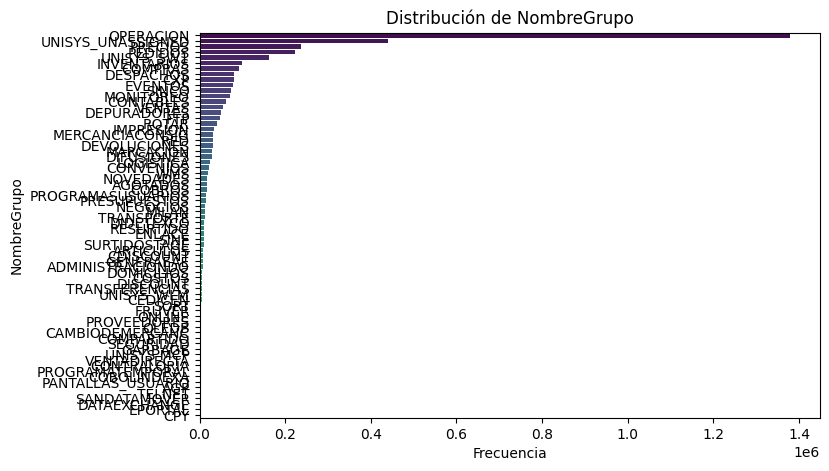

In [25]:
plt.figure(figsize=(8, 5))
sns.countplot(y=df['NombreGrupo'], order=df['NombreGrupo'].value_counts().index, palette='viridis')
plt.title("Distribución de NombreGrupo")
plt.xlabel("Frecuencia")
plt.ylabel("NombreGrupo")
plt.show()

In [7]:
mean_total_mipsFecha_per_day = df.groupby('Fecha')['total_mipsFecha'].mean().reset_index()
mean_total_mipsFecha_per_day.columns = ['Fecha', 'Mean_total_mipsFecha']
stat, p_value = stats.shapiro(mean_total_mipsFecha_per_day['Mean_total_mipsFecha'])
print(f'Shapiro-Wilk test statistic: {stat}, p-value: {p_value}')
#mean_total_mipsFecha_per_day.to_csv('//home//mips-sinco-estadisticas//app//exploratory_analysis//mean_total_mipsFecha_per_day.csv', index=False, decimal=',')
print(mean_total_mipsFecha_per_day)

Shapiro-Wilk test statistic: 0.9217511928179241, p-value: 9.835019839130778e-27
          Fecha  Mean_total_mipsFecha
0    2021-01-01              0.046552
1    2021-01-02              0.042198
2    2021-01-03              0.042230
3    2021-01-04              0.054479
4    2021-01-05              0.047093
...         ...                   ...
1439 2024-12-11              0.040147
1440 2024-12-12              0.038356
1441 2024-12-13              0.040625
1442 2024-12-14              0.034053
1443 2024-12-15              0.035630

[1444 rows x 2 columns]


In [8]:
category_counts = df['NombreProceso'].value_counts().reset_index()
category_counts.columns = ['NombreProceso', 'Count']
print(category_counts)

                       NombreProceso  count
0                 *SMA/MCP/INTERFACE   4239
1                     *FILE/TRANSFER   3948
2               *LIBRARY/MAINTENANCE   3190
3               *SYSTEM/OLEDB/WORKER   3097
4               SMA/WFL/PROCESSCHECK   2961
...                              ...    ...
9675  (SINCO)PSINCO/CRACTCEDB ON EXF      1
9676         (SINCO)FIXUP/DEREPDTOC/      1
9677       (SINCO)SORT/CEDT/CEDTNOMG      1
9678          (SINCO)GENERATE/CEPCH/      1
9679               (SINCO)CDS/CEBUT/      1

[9680 rows x 2 columns]


In [ ]:
df = df.merge(category_counts, on='NombreProceso', how='left')
df_analysis = df[['Count', 'total_mipsFecha']]
filtered_df = df_analysis[df_analysis['Count'] <= 29]

plt.figure(figsize=(12, 8))
plt.boxplot([filtered_df[filtered_df['Count'] == count]['total_mipsFecha'] for count in filtered_df['Count'].unique()],
            labels=filtered_df['Count'].unique())
plt.xlabel('Count')
plt.ylabel('total_mipsFecha')
plt.title('Boxplot of total_mipsFecha for Counts less than 29')
plt.grid(True)
plt.show()

#df_analysis.to_csv('//home//mips-sinco-estadisticas//app//exploratory_analysis//distribution_mips_by_count.csv', index=False, decimal=',')
print(category_counts)

normality_results = []

for count in filtered_df['Count'].unique():
    subset = filtered_df[filtered_df['Count'] == count]['total_mipsFecha']
    stat, p_value = stats.shapiro(subset)
    normality_results.append({'Count': count, 'p-value': p_value})

normality_df = pd.DataFrame(normality_results)
print(normality_df)

count_proportions = category_counts['Count'].value_counts(normalize=True).reset_index()
count_proportions.columns = ['Count', 'Proportion']
    
count_proportions.to_csv('//home//mips-sinco-estadisticas//app//exploratory_analysis//proportions.csv', index=False, decimal=',')

plt.figure(figsize=(10, 8))
plt.barh(count_proportions['Count'], count_proportions['Proportion'], color='skyblue')
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Proportion of Counts')
plt.grid(axis='x')
    
print(count_proportions)